In [1]:
# first, we'll import the relevent packages

# these help us work with the data
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# this is for standardizing in preperation for modeling
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# these take care of cross-validation and the test-train split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV 

# our ML methods
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF

# for performance evaluation of the model
import sklearn.metrics as m

# for model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)
# for various plots
from sklearn import tree # the decision tree

# modeling infrastructure
from sklearn.pipeline import Pipeline

In [2]:
# we load the data set as a pandas dataframe
data = pd.read_csv("final.csv")
data.shape

(11100, 496)

In [3]:
data = data.dropna()

In [4]:
y = data[['Reelected']]
X = data.drop('Reelected', axis = 'columns')
print(y.shape)
print(X.shape)

(9512, 1)
(9512, 495)


In [5]:
train_X, test_X, train_y, test_y =  train_test_split(X,y,test_size=.25,random_state=202011)

In [6]:
print(train_X.shape[0]/data.shape[0])
print(test_X.shape[0]/data.shape[0])

0.75
0.25


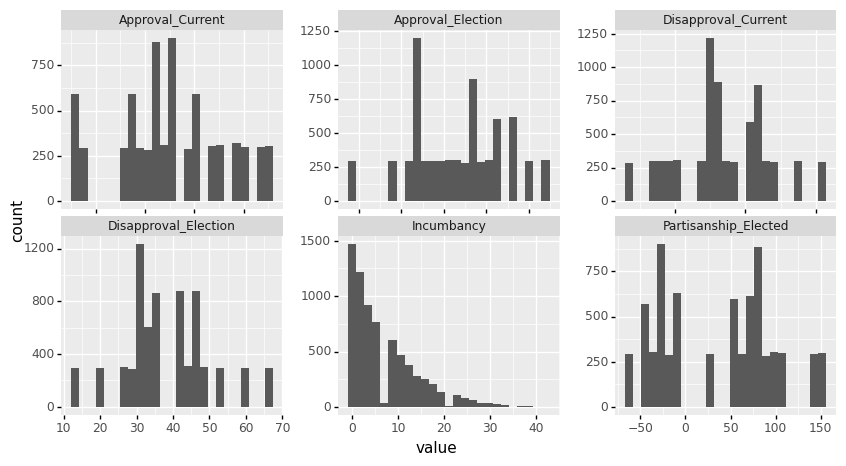

<ggplot: (154957720652)>

In [7]:
visual_1 = train_X[['Approval_Election', 'Disapproval_Election', 'Approval_Current', 'Disapproval_Current', 'Partisanship_Elected', 'Incumbancy']].melt()
(
    ggplot(visual_1,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

In [11]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['Approval_Election', 'Disapproval_Election', 'Approval_Current', 'Disapproval_Current', 'Partisanship_Elected', 'Incumbancy'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[1,2,3,5]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[2,4,6],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)



# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Approval_Election',
                                                                          'Disapproval_Election',
                                                                          'Approval_Current',
                                                                          'Disapproval_Current',
                                                                          'Partisanship_Elected',
                                                                          'Incumbancy'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [KNeighborsClassif

In [13]:
search.best_params_

{'model': RandomForestClassifier(max_depth=6, n_estimators=1000),
 'model__max_depth': 6,
 'model__n_estimators': 1000}

In [18]:
search.best_score_

-0.1882545695075242

In [15]:
rf_mod = search.best_estimator_

In [16]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.7004674232765503

In [17]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=25)

KeyboardInterrupt: 